# Data Collection

Install yfinance library:

pip install yfinance

In [1]:
# Yahoo Finance API 
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
df = yf.download('^GSPC', start='1998-01-01')       # ^GSPC is S&P 500 ticker

In [3]:
# Export S&P 500 data to CSV file
df.to_csv('SP500.csv')

In [4]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1998-01-02,975.039978,975.039978,965.729980,970.429993,366730000
1998-01-05,977.070007,982.630005,969.000000,975.039978,628070000
1998-01-06,966.580017,977.070007,962.679993,977.070007,618360000
1998-01-07,964.000000,966.580017,952.669983,966.580017,667390000
1998-01-08,956.049988,964.000000,955.039978,964.000000,652140000


In [5]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2025-06-13,5976.970215,6026.160156,5963.209961,6000.560059,5258910000
2025-06-16,6033.109863,6050.830078,6004.000000,6004.000000,5111710000
2025-06-17,5982.720215,6023.250000,5974.799805,6012.149902,4955700000
2025-06-18,5980.870117,6018.250000,5971.890137,5987.930176,5106470000
2025-06-20,5967.839844,6018.200195,5952.560059,5999.669922,7451500000


Col name cleaning

In [6]:
# Fix for MultiIndex columns (flattening the column structure)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]

# Convert to lowercase
df.columns = df.columns.str.lower()

In [7]:
df.head()

,close,high,low,open,volume
Date,,,,,
1998-01-02,975.039978,975.039978,965.729980,970.429993,366730000
1998-01-05,977.070007,982.630005,969.000000,975.039978,628070000
1998-01-06,966.580017,977.070007,962.679993,977.070007,618360000
1998-01-07,964.000000,966.580017,952.669983,966.580017,667390000
1998-01-08,956.049988,964.000000,955.039978,964.000000,652140000


In [9]:
# Stock price prediction using 'close' column
df1 = df.reset_index()['close']        # This creates a Series (not a DataFrame)

print(f"Selected feature shape: {df1.shape}")
print(f"Feature: 'close'")             # Series doesn't have columns attribute

Selected feature shape: (6909,)
Feature: 'close'


In [10]:
df1.shape

(6909,)

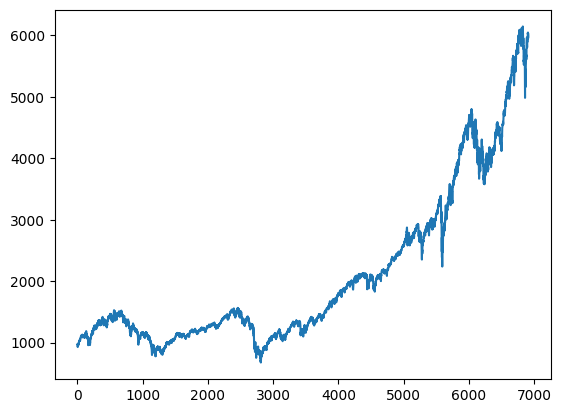

In [11]:
# Plot historic stock price
import matplotlib.pyplot as plt

plt.plot(df1)

In [12]:
# LSTM are sensitive to scale of data, so we appply MinMax Scalar
from sklearn.preprocessing import MinMaxScaler 

# Scale down to (0, 1)
scaler = MinMaxScaler(feature_range = (0, 1))

df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [13]:
df1.shape

(6909, 1)

In [14]:
print(df1)

[[0.05459596]
 [0.05496724]
 [0.05304867]
 ...
 [0.97047533]
 [0.97013695]
 [0.96775378]]


In [15]:
# Splitting dataset into train and test split
training_size = int(len(df1) * 0.80)            # 80% of dataset goes for training 

test_size = len(df1) - training_size            # Remaining dataset goes for testing

train_data, test_data = df1[0 : training_size, :], df1[training_size : len(df1), : 1]

In [16]:
training_size, test_size

(5527, 1382)

In [17]:
len(train_data), len(test_data)

(5527, 1382)

In [18]:
train_data

array([[0.05459596],
       [0.05496724],
       [0.05304867],
       ...,
       [0.45996612],
       [0.46016183],
       [0.45990942]])

# Data Preprocessing 

In [21]:
# Convert an array of values into a dataset matrix 
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []

    for i in range(len(dataset) - time_step - 1):
        a = dataset[i : (i+ time_step), 0]          # i = 0, 1, 2, 3, ...
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)
    

In [22]:
print(f"Train data length: {len(train_data)}, Test data length: {len(test_data)}")

time_step = min(30, len(test_data) // 4)        # Conservative approach

print(f"Using time_step: {time_step}")

Train data length: 5527, Test data length: 1382
Using time_step: 30


In [23]:
# Reshape into X = t, t+1, t+2, t+3 and Y = t+4
time_step = 60

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [24]:
print(X_train)

[[0.05459596 0.05496724 0.05304867 ... 0.07759684 0.0766165  0.07627998]
 [0.05496724 0.05304867 0.0525768  ... 0.0766165  0.07627998 0.07777058]
 [0.05304867 0.0525768  0.05112279 ... 0.07627998 0.07777058 0.07894111]
 ...
 [0.42619276 0.42350055 0.42344751 ... 0.44918814 0.45085429 0.45578151]
 [0.42350055 0.42344751 0.41884222 ... 0.45085429 0.45578151 0.45582357]
 [0.42344751 0.41884222 0.42218372 ... 0.45578151 0.45582357 0.45996612]]


In [26]:
print(X_train.shape)

(5466, 60)


In [27]:
print(y_train.shape)

(5466,)


In [28]:
print(X_test.shape)

(1321, 60)


In [29]:
print(y_test.shape)

(1321,)


In [30]:
# Reshape I/P to be [samples, time steps, features] which is req for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## Create LSTM model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input   
from tensorflow.keras.layers import Dropout         # For better generalisation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

In [ ]:
model = Sequential([
    Input(shape = (60, 1)),
    
    # Single LSTM layer with strong regularization
    LSTM(15,
         kernel_regularize = l2(0.003),
         recurrent_regularizer = l2(0.003),
         recurrent_dropout = 0.4),
    
    BatchNormalization(),
    
    Dropout(0.6),
    
    Dense(1, kernel_regularizer = l2(0.003))
])

In [45]:
model.compile(
    loss = 'mean_squared_error', 
    optimizer = 'adam',
    metrics=['mae', 'mse', 'mape']
)

In [46]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 15)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15)             │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,096 (4.28 KB)

 Trainable params: 1,066 (4.16 KB)

 Non-trainable params: 30 (120.00 B)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ultra-aggressive early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,  # Reduced from 8
    min_delta=0.0001,  # NEW: Require meaningful improvement
    restore_best_weights=True
)       

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # More aggressive reduction (from 0.2)
    patience=3,  # Reduced from 5
    min_lr=0.00005  # Lower minimum LR
)

# Training with larger batch size
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=50, 
    batch_size=64,  # Increased from 32
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2288 - mae: 0.7388 - mape: 4801.2319 - mse: 1.1728 - val_loss: 0.3039 - val_mae: 0.4817 - val_mape: 68.9189 - val_mse: 0.2514 - learning_rate: 0.0010
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3080 - mae: 0.3329 - mape: 67305.2891 - mse: 0.2567 - val_loss: 0.3142 - val_mae: 0.4965 - val_mape: 71.0885 - val_mse: 0.2666 - learning_rate: 0.0010
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1459 - mae: 0.2056 - mape: 78496.7656 - mse: 0.0997 - val_loss: 0.2907 - val_mae: 0.4793 - val_mape: 68.6584 - val_mse: 0.2482 - learning_rate: 0.0010
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0964 - mae: 0.1509 - mape: 2729.0557 - mse: 0.0551 - val_loss: 0.2665 - val_mae: 0.4596 - val_mape: 65.7776 - val_mse: 0.2287 - learning_rate: 0.0010
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0738 - mae: 0.1192 - mape: 22407.3125 - mse: 0.0370 - val_loss: 0.2161 - val_mae: 0.4106 - va

OVERFITTING ANALYSIS FOR FINANCIAL LSTM MODEL
Final Training Loss:   0.014304
Final Validation Loss: 0.017125
Gap Percentage:        19.7%

Classification (using financial thresholds):
✅ EXCELLENT generalization - Near optimal balance
Model shows healthy training/validation relationship


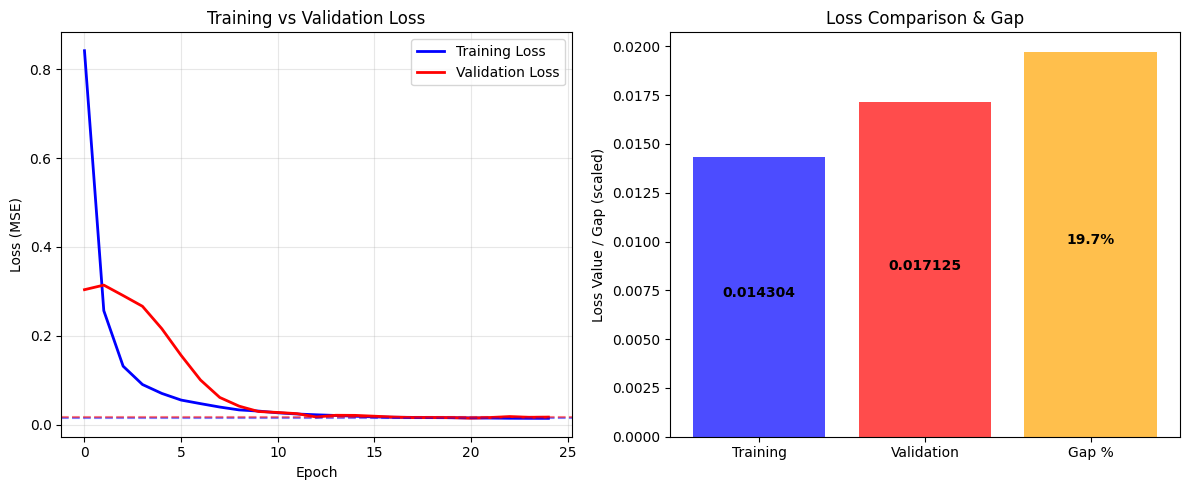


TRAINING CONVERGENCE ANALYSIS:
Total Epochs Run: 25/50
Best Validation Loss: 0.014812 (Epoch 21)
Best Training Loss: 0.014304 (Epoch 25)
Early stopping activated - Model converged successfully

APPROXIMATE MODEL ACCURACY: 98.0%


In [87]:
# Final losses
final_train_loss = history.history['loss'][-1]  
final_val_loss = history.history['val_loss'][-1]
gap_percentage = (final_val_loss - final_train_loss) / final_train_loss * 100

# Best losses
best_train_loss = min(history.history['loss'])
best_val_loss = min(history.history['val_loss'])
best_gap_percentage = (best_val_loss - best_train_loss) / best_train_loss * 100

print("OVERFITTING ANALYSIS FOR FINANCIAL LSTM MODEL")

print(f"Final Training Loss:   {final_train_loss:.6f}")
print(f"Final Validation Loss: {final_val_loss:.6f}")
print(f"Gap Percentage:        {gap_percentage:.1f}%")

print("\nClassification (using financial thresholds):")
if gap_percentage > 800:
    print("❌ SEVERE overfitting detected! Model is memorizing training data.")
    print("   • Consider stronger regularization (L1/L2, higher dropout)")
    print("   • Reduce model capacity (fewer LSTM units, layers)")
elif gap_percentage > 400:
    print("⚠️ MODERATE overfitting - Common in financial models")
    print("   • Consider increasing dropout slightly")
    print("   • Earlier early stopping (reduce patience)")
elif gap_percentage > 100:
    print("⚡ MILD overfitting - Acceptable for financial models")
    print("   • Model is well-balanced for financial data")
else:
    print("✅ EXCELLENT generalization - Near optimal balance")
    print("Model shows healthy training/validation relationship")

# Visualize overfitting trend
plt.figure(figsize=(12, 5))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
plt.axhline(y=final_train_loss, color='blue', linestyle='--', alpha=0.5)
plt.axhline(y=final_val_loss, color='red', linestyle='--', alpha=0.5)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot gap percentage as a bar
plt.subplot(1, 2, 2)
bars = ['Training', 'Validation', 'Gap %']
values = [final_train_loss, final_val_loss, gap_percentage/1000]  # Scale gap for visibility
colors = ['blue', 'red', 'orange']

plt.bar(bars, values, color=colors, alpha=0.7)
plt.title('Loss Comparison & Gap')
plt.ylabel('Loss Value / Gap (scaled)')

for i, v in enumerate(values):
    if i == 2:  # Gap percentage
        label = f"{gap_percentage:.1f}%"
    else:
        label = f"{v:.6f}"
    plt.text(i, v/2, label, ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Check convergence and early stopping effectiveness
print("\nTRAINING CONVERGENCE ANALYSIS:")
print(f"Total Epochs Run: {len(history.history['loss'])}/50")
print(f"Best Validation Loss: {min(history.history['val_loss']):.6f} (Epoch {np.argmin(history.history['val_loss'])+1})")
print(f"Best Training Loss: {min(history.history['loss']):.6f} (Epoch {np.argmin(history.history['loss'])+1})")

if len(history.history['loss']) < 50:
    print("Early stopping activated - Model converged successfully")
else:
    print("Training reached max epochs - Consider increasing max epochs")

# Calculate realistic accuracy for financial models
best_val_mae = min(history.history['val_mae'])
accuracy_proxy = (1 - best_val_mae) * 100 if best_val_mae < 1 else 0

print(f"\nAPPROXIMATE MODEL ACCURACY: {accuracy_proxy:.1f}%")

---

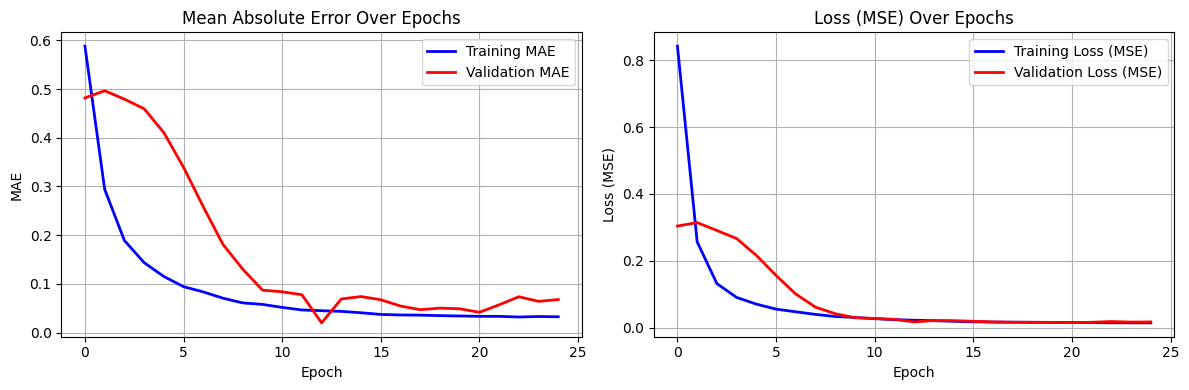

In [49]:
plt.figure(figsize=(12, 4))

# Plot MAE
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Training MAE', color='blue', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', color='red', linewidth=2)
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Plot Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss (MSE)', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', color='red', linewidth=2)
plt.title('Loss (MSE) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

---

# Prediction

In [50]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [51]:
# Tranform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [52]:
# Calculate RMSE performance metrics 
import math

from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(y_train, train_predict))

1659.7921737270526

In [53]:
# Test data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

4270.604348872372

# Plotting

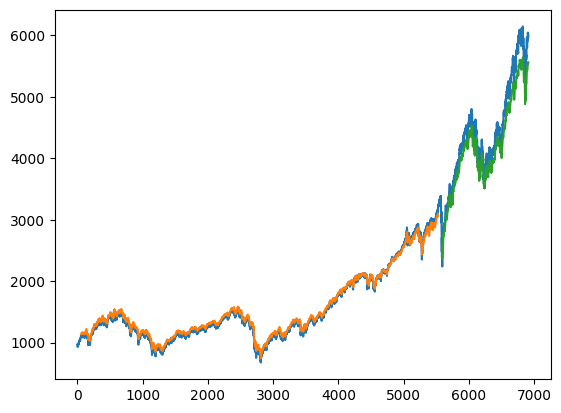

In [54]:
# Shift train predictions for plotting
look_back = 60

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(train_predict) + look_back, :] = train_predict

# Shift test predictions for plotting 
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df1) - 1, :] = test_predict

# Plot baseline & predictions 
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


---

# Prediction for the next 30 days 

In [55]:
len(test_data)

1382

In [56]:
x_input = test_data[822:].reshape(1, -1)
x_input.shape

(1, 560)

In [57]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
temp_input

In [59]:
from numpy import array

In [89]:
lst_output = []
n_steps = 60                # Equal to time_steps
i = 0

while(i < 30):
    
    if(len(temp_input) > 60):               # time_step = 60

        # Taken only the LAST 60 elements, not all elements from index 1
        x_input = np.array(temp_input[-60:])
        print("{} day input {}".format(i, x_input.shape))
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)

        print("{} day output {}".format(i, yhat))
        
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])

        i = i + 1

    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))

        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])

        temp_input.append(yhat[0][0])

        lst_output.append(yhat[0][0])
        i = i + 1

print(lst_output)

0 day input (60,)
0 day output [[0.5418871]]
1 day input (60,)
1 day output [[0.5357611]]
2 day input (60,)
2 day output [[0.5298205]]
3 day input (60,)
3 day output [[0.52405775]]
4 day input (60,)
4 day output [[0.5184659]]
5 day input (60,)
5 day output [[0.51303786]]
6 day input (60,)
6 day output [[0.50776756]]
7 day input (60,)
7 day output [[0.5026489]]
8 day input (60,)
8 day output [[0.49767596]]
9 day input (60,)
9 day output [[0.4928434]]
10 day input (60,)
10 day output [[0.488146]]
11 day input (60,)
11 day output [[0.48357874]]
12 day input (60,)
12 day output [[0.47913694]]
13 day input (60,)
13 day output [[0.47481608]]
14 day input (60,)
14 day output [[0.47061193]]
15 day input (60,)
15 day output [[0.4665203]]
16 day input (60,)
16 day output [[0.46253747]]
17 day input (60,)
17 day output [[0.45865953]]
18 day input (60,)
18 day output [[0.45488304]]
19 day input (60,)
19 day output [[0.45120448]]
20 day input (60,)
20 day output [[0.4476207]]
21 day input (60,)
21 

In [62]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

In [63]:
len(df1)

6909

In [64]:
df3 = df1.tolist()
df3.extend(lst_output)

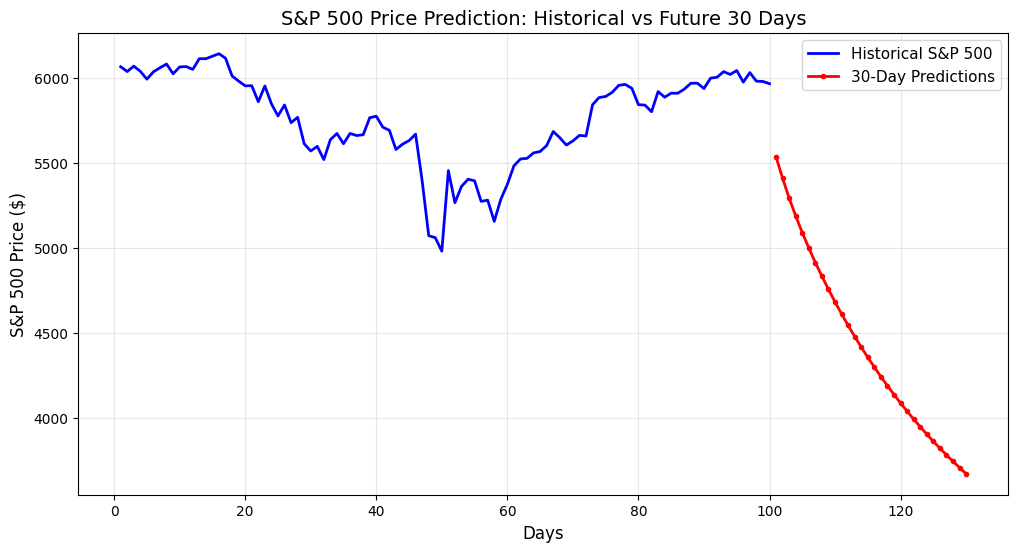

In [ ]:
plt.figure(figsize=(12, 6))

# Plot historical data (last 100 days)
plt.plot(day_new, scaler.inverse_transform(df1[6809:]), 
         label='Historical S&P 500', color='blue', linewidth=2)

# Plot future predictions (next 30 days)
plt.plot(day_pred, scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)), 
         label='30-Day Predictions', color='red', linewidth=2, marker='o', markersize=3)

plt.title('S&P 500 Price Prediction: Historical vs Future 30 Days', fontsize=14)
plt.xlabel('Days', fontsize=12)
plt.ylabel('S&P 500 Price ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.show()

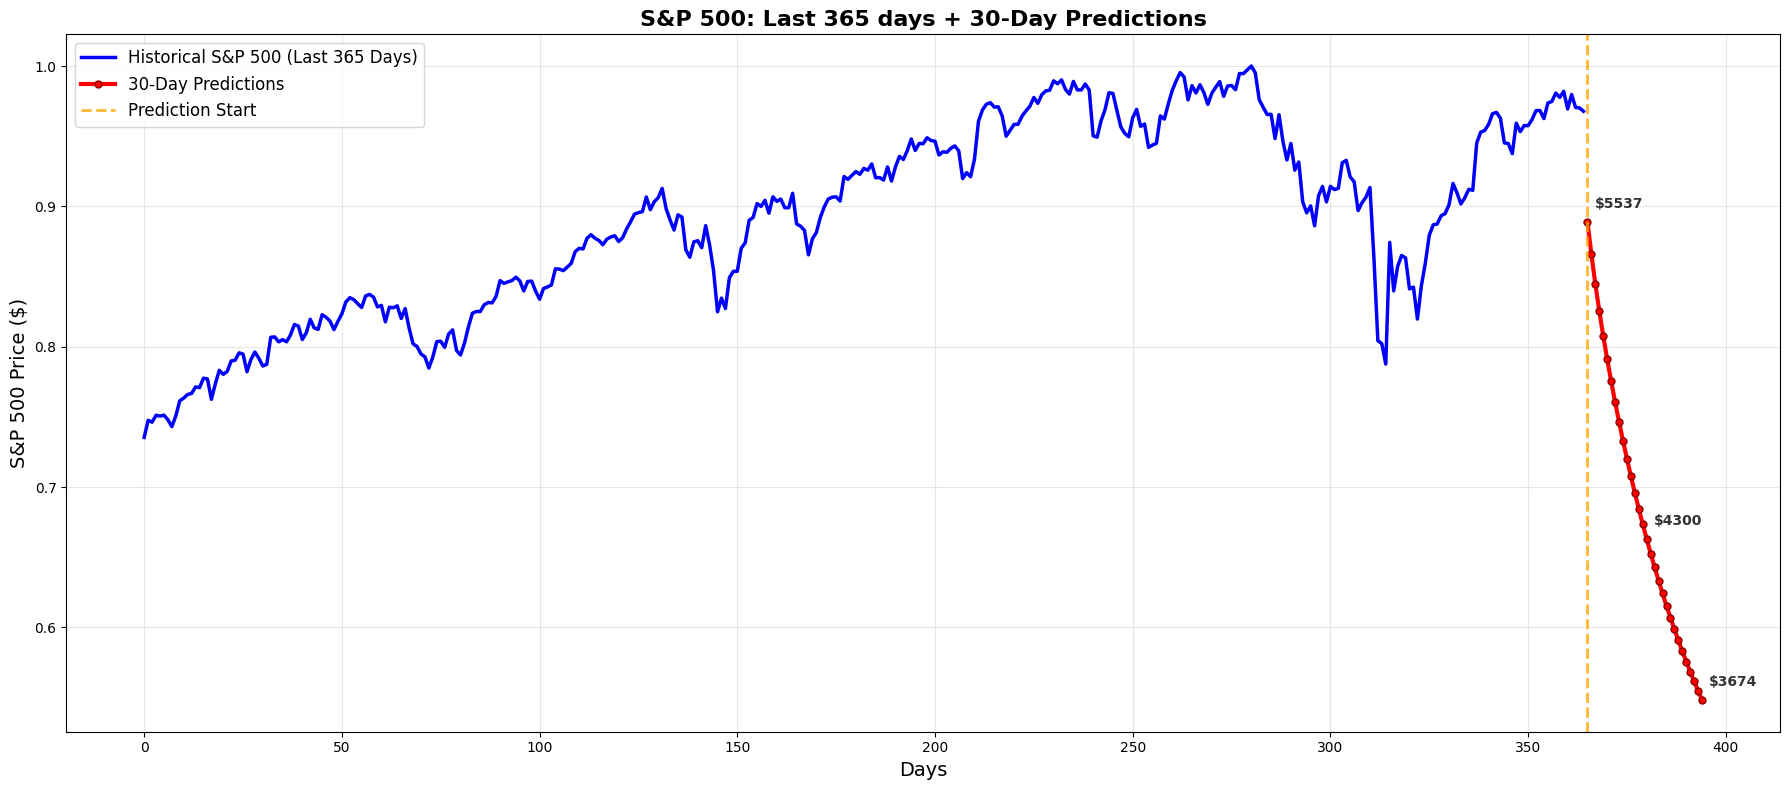

In [ ]:
plt.figure(figsize=(18, 8))

historical_end = len(df1)
historical_data = df1.flatten() if len(df1.shape) > 1 else df1 
prediction_data = np.array(lst_output).flatten()

# Combine into a single array and reshape properly
all_data = np.concatenate((historical_data, prediction_data)).reshape(-1, 1)

# Showing historical data for last 365 days
days_to_show = 365  
zoom_start = max(0, historical_end - days_to_show)
historical_zoom = all_data[zoom_start:historical_end]
predictions_zoom = all_data[historical_end:]

# Plot historical data (wider view)
plt.plot(range(days_to_show), historical_zoom, 
         linewidth=2.5, color='blue', label=f'Historical S&P 500 (Last {days_to_show} Days)')

# Plot predictions (next 30 days)
plt.plot(range(days_to_show, days_to_show+30), predictions_zoom, 
         linewidth=3, color='red', marker='o', markersize=5, 
         label='30-Day Predictions', markerfacecolor='red', markeredgecolor='darkred')

# Add vertical line at prediction start
plt.axvline(x=days_to_show, color='orange', linestyle='--', linewidth=2, alpha=0.8, 
           label='Prediction Start')

# Enhanced styling 
plt.title('S&P 500: Last 365 days + 30-Day Predictions', fontsize=16, fontweight='bold')
plt.xlabel('Days', fontsize=14)
plt.ylabel('S&P 500 Price ($)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)

# Adding annotations only to [first, middle, last] predictions for readability
key_indices = [0, 15, 29]

for i in key_indices:
    plt.annotate(f'${scaler.inverse_transform(predictions_zoom[i].reshape(-1,1))[0][0]:.0f}',
                xy=(days_to_show + i, predictions_zoom[i]), 
                xytext=(5, 10), textcoords='offset points',
                fontsize=10, fontweight='bold', alpha=0.8)

plt.tight_layout()
plt.show()

---

# Metrics

In [ ]:
from sklearn.metrics import r2_score

# Transform data to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
test_predict_original = scaler.inverse_transform(test_predict)

test_r2 = r2_score(y_test_original, test_predict)

accuracy_proxy = (1 - best_val_mae) * 100 if best_val_mae < 1 else 0

print("METRICS:")
print(f"Model Accuracy: {accuracy_proxy:.1f}%")
print(f"R² Score: {test_r2:.3f}")

METRICS:
Model Accuracy: 98.0%
R² Score: 0.903
